In [1]:
import os

In [2]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TRAVILY_API_KEY")

In [3]:
# Import relevant functionality
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

In [4]:
memory = MemorySaver()
model = ChatGroq(model="deepseek-r1-distill-llama-70b",
    temperature=0.6,
    api_key=os.getenv("GROQ_API_KEY"))

In [5]:
search = TavilySearchResults(max_results=2)
tools = [search]
agent_executor = create_react_agent(model, tools, checkpointer=memory)

In [6]:
# Use the agent
config = {"configurable": {"thread_id": "abc123"}}
for step in agent_executor.stream(
    {"messages": [HumanMessage(content="hi im bob! and i live in sf")]},
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

hi im bob! and i live in sf
================================== Ai Message ==================================

Hello Bob! How do you like living in San Francisco?


In [7]:
for step in agent_executor.stream(
    {"messages": [HumanMessage(content="whats the weather where I live?")]},
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

whats the weather where I live?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_7xex)
 Call ID: call_7xex
  Args:
    query: San Francisco weather today
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weather in San Francisco", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1741977741, 'localtime': '2025-03-14 11:42'}, 'current': {'last_updated_epoch': 1741977000, 'last_updated': '2025-03-14 11:30', 'temp_c': 11.7, 'temp_f': 53.1, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph'

In [15]:
from langgraph.graph import START, MessagesState, StateGraph

In [16]:
new_model = ChatGroq(model="deepseek-r1-distill-llama-70b",
    temperature=0.6,
    api_key=os.getenv("GROQ_API_KEY"))

In [17]:
workflow = StateGraph(state_schema=MessagesState)

In [18]:
def call_model(state: MessagesState):
    response = new_model.invoke(state["messages"])
    return {"messages": response}

In [19]:
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

In [20]:
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

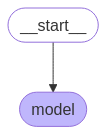

In [21]:
app

In [22]:
query = "Hi! I'm Bob."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print() 

================================== Ai Message ==================================

<think>

</think>

Hi Bob! How can I assist you today? 😊
